# Common

In [1]:
import os
import numpy as np
from sklearn import neighbors as knn
from glob import glob
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import itertools
import dlib
from natsort import natsorted

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_DIR = '/content/drive/MyDrive/dl_for_cv/data/cbcl/'

In [6]:
%cd '/content/drive/MyDrive/dl_for_cv/data/cbcl'

/content/drive/MyDrive/dl_for_cv/data/cbcl


# MIT-CBCL

Download the dataset from [here](http://cbcl.mit.edu/software-datasets/heisele/facerecognition-database.html) and place it on your Google Drive in the folder set above.

# Dataset preparation

First of all, extract all the data:

In [7]:
%cd $DATA_DIR
!unzip -o MIT-CBCL-facerec-database.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test/0001_00740.pgm     
  inflating: test/0001_00741.pgm     
  inflating: test/0001_00742.pgm     
  inflating: test/0001_00743.pgm     
  inflating: test/0001_00745.pgm     
  inflating: test/0001_00794.pgm     
  inflating: test/0001_00795.pgm     
  inflating: test/0001_00798.pgm     
  inflating: test/0001_00802.pgm     
  inflating: test/0001_00803.pgm     
  inflating: test/0001_00804.pgm     
  inflating: test/0001_00865.pgm     
  inflating: test/0001_00866.pgm     
  inflating: test/0001_00868.pgm     
  inflating: test/0001_00870.pgm     
  inflating: test/0001_00923.pgm     
  inflating: test/0001_00926.pgm     
  inflating: test/0001_01255.pgm     
  inflating: test/0001_01263.pgm     
  inflating: test/0001_01265.pgm     
  inflating: test/0001_01268.pgm     
  inflating: test/0001_01269.pgm     
  inflating: test/0001_01270.pgm     
  inflating: test/0001_01271.pgm     
  inflating: test/00

Here we go..

In [8]:
files_db = [
    '0000_00000001.jpg', '0001_00000001.jpg', '0002_1.jpg',
    '0003_00000001.jpg', '0004_1.jpg', '0005_16.jpg', '0006_001.jpg'
]

print(len(files_db))

7


In [9]:
files_query = [
               os.path.basename(f) for f in glob(os.path.join(
                   DATA_DIR,
                   'training-originals',
                   '*.jpg'
                   ))
               ]
files_query = np.asarray(natsorted([f for f in files_query if f not in files_db]))

print(files_query.shape)

(52,)


In [10]:
files_query

array(['0000_00000002.jpg', '0000_00000003.jpg', '0000_00000004.jpg',
       '0000_00000005.jpg', '0001_00000002.jpg', '0001_00000003.jpg',
       '0001_00000004.jpg', '0001_00000005.jpg', '0002_2.jpg',
       '0002_3.jpg', '0002_4.jpg', '0002_5.jpg', '0002_7.jpg',
       '0003_00000002.jpg', '0003_00000003.jpg', '0003_00000004.jpg',
       '0003_00000005.jpg', '0004_2.jpg', '0004_3.jpg', '0004_4.jpg',
       '0004_5.jpg', '0004_6.jpg', '0005_17.jpg', '0005_18.jpg',
       '0005_19.jpg', '0005_20.jpg', '0005_21.jpg', '0005_22.jpg',
       '0005_23.jpg', '0006_002.jpg', '0006_003.jpg', '0006_004.jpg',
       '0006_005.jpg', '0006_006.jpg', '0007_002.jpg', '0007_003.jpg',
       '0007_004.jpg', '0007_005.jpg', '0007_006.jpg', '0008_001.jpg',
       '0008_002.jpg', '0008_003.jpg', '0008_004.jpg', '0008_005.jpg',
       '0008_006.jpg', '0008_007.jpg', '0009_002.jpg', '0009_003.jpg',
       '0009_004.jpg', '0009_005.jpg', '0009_006.jpg', '0009_007.jpg'],
      dtype='<U17')

# 1st-level predictor

In [11]:
%cd /content/drive/MyDrive/dl_for_cv/

/content/drive/MyDrive/dl_for_cv


Our 1st-level predictor (aka embedding generator). Essentially this is ResNet-50 slighlty modified for REID heads. See [origin](https://github.com/TreB1eN/InsightFace_Pytorch) and big thanks authors for their work!

In [12]:
FACE_SIZE = 112

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

*Model definition from [this file](https://github.com/TreB1eN/InsightFace_Pytorch/blob/master/model.py).*

In [14]:
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module
from collections import namedtuple

class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def l2_norm(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

class SEModule(Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = AdaptiveAvgPool2d(1)
        self.fc1 = Conv2d(
            channels, channels // reduction, kernel_size=1, padding=0 ,bias=False)
        self.relu = ReLU(inplace=True)
        self.fc2 = Conv2d(
            channels // reduction, channels, kernel_size=1, padding=0 ,bias=False)
        self.sigmoid = Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

class bottleneck_IR(Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride ,bias=False), BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3, 3), (1, 1), 1 ,bias=False), PReLU(depth),
            Conv2d(depth, depth, (3, 3), stride, 1 ,bias=False), BatchNorm2d(depth))

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)
        return res + shortcut

class bottleneck_IR_SE(Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR_SE, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride ,bias=False),
                BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3,3), (1,1),1 ,bias=False),
            PReLU(depth),
            Conv2d(depth, depth, (3,3), stride, 1 ,bias=False),
            BatchNorm2d(depth),
            SEModule(depth,16)
            )
    def forward(self,x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)
        return res + shortcut

class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
    '''A named tuple describing a ResNet block.'''

def get_block(in_channel, depth, num_units, stride = 2):
  return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units-1)]

def get_blocks(num_layers):
    if num_layers == 50:
        blocks = [
            get_block(in_channel=64, depth=64, num_units = 3),
            get_block(in_channel=64, depth=128, num_units=4),
            get_block(in_channel=128, depth=256, num_units=14),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 100:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=13),
            get_block(in_channel=128, depth=256, num_units=30),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 152:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=8),
            get_block(in_channel=128, depth=256, num_units=36),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    return blocks

class Backbone(Module):
    def __init__(self, num_layers, drop_ratio, mode='ir'):
        super(Backbone, self).__init__()
        assert num_layers in [50, 100, 152], 'num_layers should be 50,100, or 152'
        assert mode in ['ir', 'ir_se'], 'mode should be ir or ir_se'
        blocks = get_blocks(num_layers)
        if mode == 'ir':
            unit_module = bottleneck_IR
        elif mode == 'ir_se':
            unit_module = bottleneck_IR_SE
        self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1 ,bias=False),
                                      BatchNorm2d(64),
                                      PReLU(64))
        self.output_layer = Sequential(BatchNorm2d(512),
                                       Dropout(drop_ratio),
                                       Flatten(),
                                       Linear(512 * 7 * 7, 512),
                                       BatchNorm1d(512))
        modules = []
        for block in blocks:
            for bottleneck in block:
                modules.append(
                    unit_module(bottleneck.in_channel,
                                bottleneck.depth,
                                bottleneck.stride))
        self.body = Sequential(*modules)

    def forward(self,x):
        x = self.input_layer(x)
        x = self.body(x)
        x = self.output_layer(x)
        return l2_norm(x)

Model weights are from [here](https://github.com/TreB1eN/InsightFace_Pytorch#32-detect-over-camera). **Please download it manually**.

In [15]:
model = Backbone(50, 0.0, mode='ir_se').eval()
model.load_state_dict(torch.load('model_ir_se50.pth'))
model.cuda()

Backbone(
  (input_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
  )
  (output_layer): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): Flatten()
    (3): Linear(in_features=25088, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (body): Sequential(
    (0): bottleneck_IR_SE(
      (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): PReLU(num_parameters=64)
        (3)

*This one is not related to the repo..*

In [16]:
def gen_embds(fs):
    embds, ids = [], []
    for f in tqdm(fs):
        img = cv2.imread(os.path.join(DATA_DIR, 'training-originals', f))
        _id = int(f.split('_')[0].lstrip('0').zfill(1))
        if _id > 6:
            _id = np.nan
        ids.append(_id)

        dets = face_detector(img, 1)
        if len(dets) == 0:
            embds.append(np.zeros((512,)))
            continue

        landmarks = shape_predictor(img, dets[0])
        face_crop = dlib.get_face_chip(img, landmarks, size=FACE_SIZE, padding=0.2)[:, :, [2, 1, 0]]

        with torch.no_grad():
            embd = model(transform(face_crop).unsqueeze(0).cuda())[0]
        embds.append(embd.cpu().numpy())

    return np.asarray(embds), np.asarray(ids)

See [this](http://dlib.net/face_detector.py.html) cookbook for `dlib` face detection or [this one](http://dlib.net/face_alignment.py.html) for face alignment.

In [17]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bunzip2 shape_predictor_5_face_landmarks.dat.bz2

--2025-05-10 11:01:38--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2 [following]
--2025-05-10 11:01:39--  https://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2.1’

shape_predictor_5_f 100%[===================>]   5.44M  2.47MB/s    in 2.2s    

2025-05-10 11:01:42 (2.47 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2.1’ saved [5706710/5706710]

bunzip2: Output file shape_predictor_5_face_landmarks.dat already exists.


In [19]:
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

Let's detect face and generate embeddings:

In [20]:
embds_db, ids_db = gen_embds(files_db)
embds_query, ids_query = gen_embds(files_query)

print(embds_db.shape, ids_db.shape)
print(embds_query.shape, ids_query.shape)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

(7, 512) (7,)
(52, 512) (52,)


Filter-out images where face wasn't detected:

In [21]:
inds = np.abs(embds_db).sum(axis=1) > 0

embds_db = embds_db[inds]
ids_db = ids_db[inds]

print(embds_db.shape, ids_db.shape)

(7, 512) (7,)


In [22]:
inds = np.abs(embds_query).sum(axis=1) > 0

embds_query = embds_query[inds]
ids_query = ids_query[inds]

print(embds_query.shape, ids_query.shape)

(35, 512) (35,)


Just sanity check:

In [23]:
assert np.unique(ids_db).size == ids_db.max() + 1

# 2nd-level predictor

Let's manually define useful metrics for clarity:

In [24]:
def cosine_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [25]:
def cosine_dist(v1, v2):
    return 1 - cosine_sim(v1, v2)

In [26]:
def euc_dist(v1, v2):
    return np.linalg.norm(v1 - v2)

*(you can find them into numpy / scipy / sklearn etc)*

In [27]:
dist_f = cosine_dist

In [28]:
classifier = knn.KNeighborsClassifier(n_neighbors=1, metric=dist_f, n_jobs=-1)
classifier.fit(embds_db, ids_db)

KNeighborsClassifier(metric=<function cosine_dist at 0x7d9e280cade0>, n_jobs=-1,
                     n_neighbors=1)

In [29]:
ids_pred = classifier.predict(embds_query)

print(ids_pred.shape)

(35,)


In [30]:
idx_known = ~np.isnan(ids_query)
idx_unknown = np.isnan(ids_query)

In [31]:
print(balanced_accuracy_score(ids_query[idx_known], ids_pred[idx_known]))

0.9047619047619048


# Evaluation

## Prerequisites

In [32]:
def plot_matrix(cm, title='Contingency matrix', normed=False):
    if normed:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=20)
#     plt.colorbar()

    _format = '.2f' if normed else ''
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], _format), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=20)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

In [33]:
def plot_hists(dists_pos, dists_other, dists_neg, nbins=100):
    plt.figure(figsize=(15, 5))

    plt.hist(dists_pos, color='r', bins=nbins, alpha=0.5, label='positive')
    plt.hist(dists_other, color='g', bins=nbins, alpha=0.5, label='other')
    plt.hist(dists_neg, color='b', bins=nbins, alpha=0.5, label='negative')

    plt.legend(fontsize=14)
    plt.grid(True)

In [34]:
def plot_far_frr(xs, ys, thrs):
    plt.figure(figsize=(15, 5))

    plt.plot(xs, ys, 'r')
    plt.grid(True)

    for x, y in zip(xs, ys):
        plt.stem([x], [y], 'k--')
    for i, thr in enumerate(thrs):
        plt.text(
            xs[i], ys[i] + 0.01, str(round(thr, 2)),
            horizontalalignment='center', verticalalignment='bottom', fontsize=14, fontweight='bold'
    )

    plt.xlabel('FAR', fontsize=18)
    plt.ylabel('FRR', fontsize=18)

    plt.tick_params(labelsize=14)

In [35]:
def plot_thresholds(xs, ys, thrs):
    plt.figure(figsize=(15, 5))

    plt.plot(thrs, xs, 'b', label='FAR', linewidth=2.0)
    plt.plot(thrs, ys, 'g', label='FRR', linewidth=2.0)
    plt.grid(True)

    plt.xlabel('threshold (distance)', fontsize=18)
    plt.ylabel('rate', fontsize=18)

    plt.legend(fontsize=14)
    plt.tick_params(labelsize=14)

Here we go..

In [36]:
cm = confusion_matrix(ids_query[idx_known], ids_pred[idx_known])

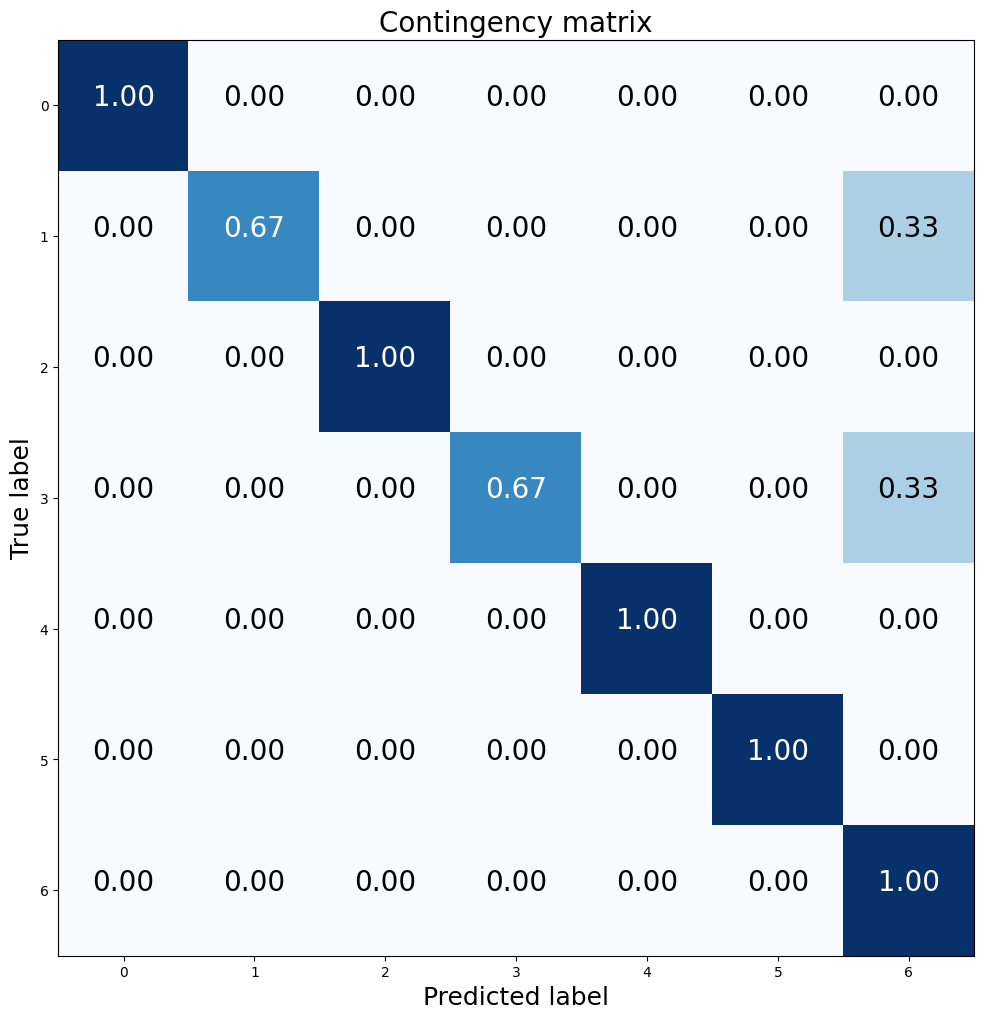

In [37]:
plot_matrix(cm, normed=True)

## Embedding analysis

Prepare for Embedding Projector visualization:

In [38]:
f_data = open('arface_cbcl.tsv', 'w')

for embd in embds_query:
    f_data.write('\t'.join([str(round(v, 4)) for v in embd]) + '\n')

f_data.flush()
f_data.close()

In [39]:
f_meta = open('arface_cbcl_meta.tsv', 'w')

f_meta.write('true\tpredicted\n')

for id1, id2 in zip(ids_query, ids_pred):
    if np.isnan(id1):
        f_meta.write('stranger\tperson{}\n'.format(int(id2)))
    else:
        f_meta.write('person{}\tperson{}\n'.format(int(id1), int(id2)))

f_meta.flush()
f_meta.close()

---

In [40]:
dmtx_db_query = np.empty((len(ids_db), len(ids_query)))

for i_db, embd_db in enumerate(tqdm(embds_db)):
    for i_query, embd_query in enumerate(embds_query):
        dmtx_db_query[i_db, i_query] = dist_f(embd_db, embd_query)

print(dmtx_db_query.shape)

  0%|          | 0/7 [00:00<?, ?it/s]

(7, 35)


In [41]:
idx_pred = dmtx_db_query.argmin(0)
ids_pred_ = np.asarray([ids_db[_id] for _id in idx_pred])

Sanity check:

In [42]:
(ids_pred[idx_known] - ids_pred_[idx_known]).sum()

np.int64(0)

In [43]:
dists_pos, dists_other, dists_neg = [], [], []

for c in tqdm(np.unique(ids_db)):
    embds_pos = embds_query[ids_query == c]
    idx = np.arange(len(embds_pos))
    for id1, id2 in itertools.combinations(idx, 2):
        dist = dist_f(embds_pos[id1], embds_pos[id2])
        dists_pos.append(dist)

    embds_other = embds_query[(idx_known) & (ids_query != c)]
    for embd_pos in embds_pos:
        for embd_other in embds_other:
            dist = dist_f(embd_pos, embd_other)
            dists_other.append(dist)

dists_neg = dmtx_db_query[:, idx_unknown].flatten()

print(len(dists_pos), len(dists_other), len(dists_neg))

  0%|          | 0/7 [00:00<?, ?it/s]

25 412 91


<StemContainer object of 3 artists>

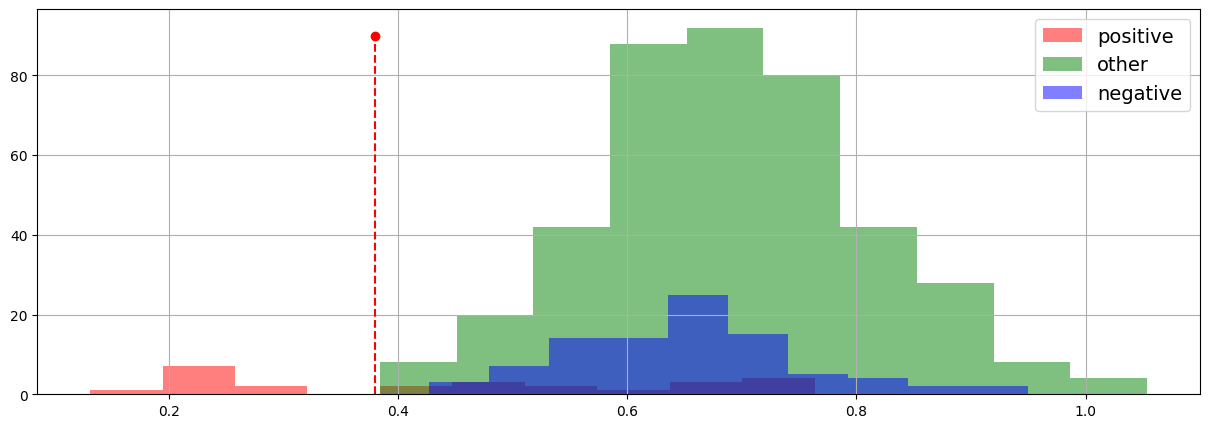

In [44]:
plot_hists(dists_pos, dists_other, dists_neg, nbins=10)
plt.stem([0.38], [90], 'r--')

## FAR/FRR

In [45]:
thrs = np.linspace(0.3, 0.8, 11)

In [46]:
thrs

array([0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ])

In [47]:
fars, frrs = [], []

dsts_pred = dmtx_db_query.min(0)
print(dsts_pred.shape)

for thr in tqdm(thrs):
    far = (dsts_pred[idx_unknown] <= thr).sum() / len(ids_query)
    fars.append(far)

    frr = (dsts_pred[idx_known] > thr).sum() / len(ids_query)
    frrs.append(frr)

#     break

fars = np.asarray(fars)
frrs = np.asarray(frrs)

print(fars.shape, frrs.shape)

(35,)


  0%|          | 0/11 [00:00<?, ?it/s]

(11,) (11,)


In [48]:
fars

array([0.        , 0.        , 0.        , 0.05714286, 0.11428571,
       0.28571429, 0.34285714, 0.34285714, 0.34285714, 0.34285714,
       0.34285714])

In [49]:
frrs

array([0.4       , 0.34285714, 0.34285714, 0.31428571, 0.25714286,
       0.22857143, 0.2       , 0.11428571, 0.08571429, 0.05714286,
       0.        ])

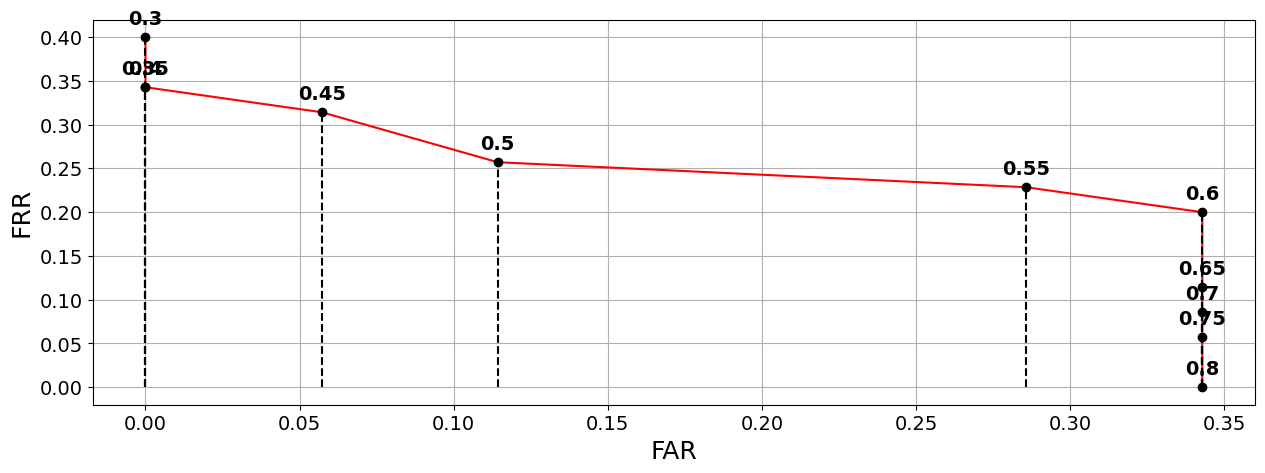

In [50]:
plot_far_frr(fars, frrs, thrs)

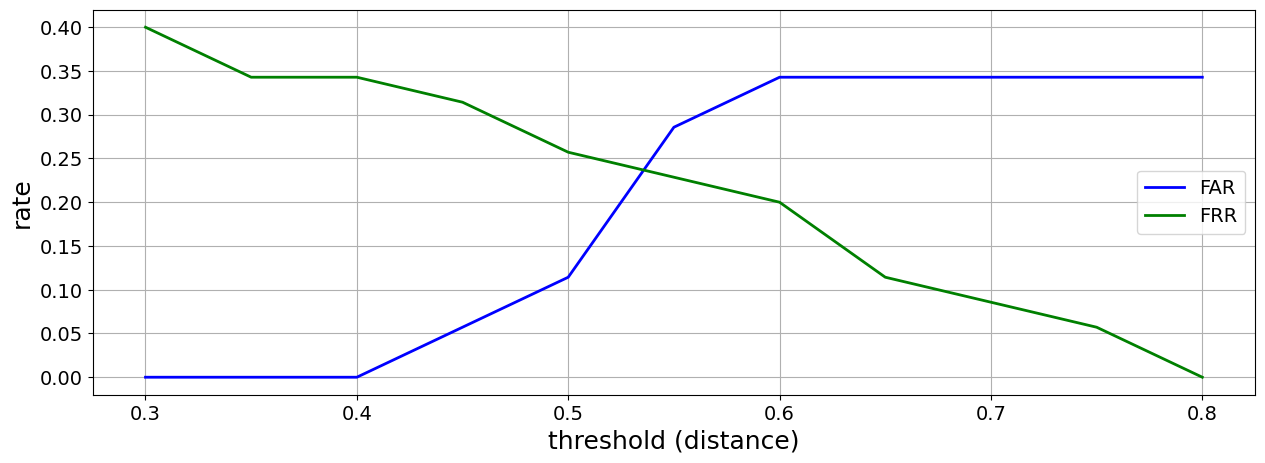

In [51]:
plot_thresholds(fars, frrs, thrs)